# Data Exploration - DeepGlobe Land Cover Classification

This notebook performs exploratory data analysis (EDA) on the DeepGlobe dataset to understand:
- Image and mask dimensions and data types
- Value ranges and distributions
- Visual characteristics of satellite imagery and corresponding segmentation masks
- Data quality and consistency

## 1.1 Load and Inspect Samples

**Objective:** Load a sample image-mask pair and inspect their properties.

**Why this matters:**
- Understand the input data format (dimensions, channels, data type)
- Verify that images and masks are properly aligned
- Check value ranges to ensure proper normalization later
- Visually confirm that masks correctly annotate the satellite images

This step establishes baseline understanding of the data before building preprocessing pipelines and models.

Image shape: (2448, 2448, 3)
Mask shape: (2448, 2448, 3)
Image dtype: uint8
Value range: [4, 255]


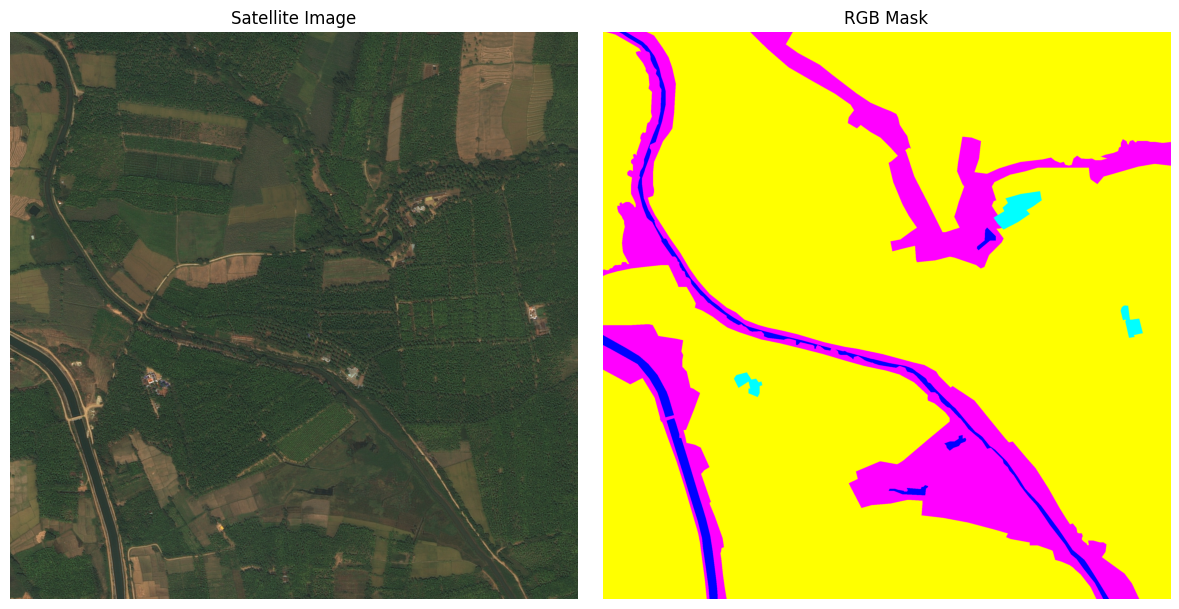

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob

# Load sample
image_path = '../data/raw/train/119_sat.jpg'
mask_path = '../data/raw/train/119_mask.png'

image = np.array(Image.open(image_path))
mask = np.array(Image.open(mask_path))

print(f"Image shape: {image.shape}")  # (2448, 2448, 3)
print(f"Mask shape: {mask.shape}")    # (2448, 2448, 3)
print(f"Image dtype: {image.dtype}")
print(f"Value range: [{image.min()}, {image.max()}]")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Satellite Image')
axes[0].axis('off')
axes[1].imshow(mask)
axes[1].set_title('RGB Mask')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## 2.2 Define Color-to-Class Mapping

**Objective:** Map RGB colors in the mask to semantic class labels.

**Why this matters:**
- DeepGlobe masks use RGB encoding where each color represents a land cover class
- Models require integer class labels (0-6), not RGB values
- This mapping is essential for converting masks during training/evaluation
- Verifying unique colors ensures data integrity and identifies any unexpected values

The color palette:
- **Cyan (0, 255, 255)** → Urban land
- **Yellow (255, 255, 0)** → Agriculture
- **Magenta (255, 0, 255)** → Rangeland
- **Green (0, 255, 0)** → Forest
- **Blue (0, 0, 255)** → Water
- **White (255, 255, 255)** → Barren land
- **Black (0, 0, 0)** → Unknown/background

In [6]:
# Official DeepGlobe color palette
COLOR_MAP = {
    (0, 255, 255): 0,    # urban (cyan)
    (255, 255, 0): 1,    # agriculture (yellow)
    (255, 0, 255): 2,    # rangeland (magenta)
    (0, 255, 0): 3,      # forest (green)
    (0, 0, 255): 4,      # water (blue)
    (255, 255, 255): 5,  # barren (white)
    (0, 0, 0): 6         # unknown (black)
}

CLASS_NAMES = [
    'urban', 'agriculture', 'rangeland',
    'forest', 'water', 'barren', 'unknown'
]

# Verify colors in mask
unique_colors = np.unique(mask.reshape(-1, 3), axis=0)
print(f"Unique colors in mask: {len(unique_colors)}")
for color in unique_colors:
    color_tuple = tuple(color)
    class_id = COLOR_MAP.get(color_tuple, -1)
    class_name = CLASS_NAMES[class_id] if class_id != -1 else "UNMAPPED"
    print(f"RGB {color_tuple} → Class {class_id} ({class_name})")

Unique colors in mask: 4
RGB (np.uint8(0), np.uint8(0), np.uint8(255)) → Class 4 (water)
RGB (np.uint8(0), np.uint8(255), np.uint8(255)) → Class 0 (urban)
RGB (np.uint8(255), np.uint8(0), np.uint8(255)) → Class 2 (rangeland)
RGB (np.uint8(255), np.uint8(255), np.uint8(0)) → Class 1 (agriculture)


## 2.3 Analyze Class Distribution

**Objective:** Calculate pixel-level class distribution across the entire training set.

**Why this matters:**
- **Class imbalance detection:** Reveals if some classes are over/under-represented
- **Loss weighting:** Imbalanced datasets benefit from weighted loss functions to prevent bias toward majority classes
- **Sampling strategy:** Informs data augmentation and sampling approaches during training
- **Baseline understanding:** Knowing class frequencies helps interpret model performance metrics

This analysis processes all training masks to count pixels per class, providing crucial insights for model design and training strategy.

Analyzing masks: 100%|██████████| 803/803 [12:03<00:00,  1.11it/s]



=== Class Distribution ===
urban       :  519,877,839 pixels ( 10.80%)
agriculture : 2,778,345,257 pixels ( 57.74%)
rangeland   :  408,259,879 pixels (  8.48%)
forest      :  537,127,505 pixels ( 11.16%)
water       :  159,404,064 pixels (  3.31%)
barren      :  406,664,162 pixels (  8.45%)
unknown     :    2,462,606 pixels (  0.05%)


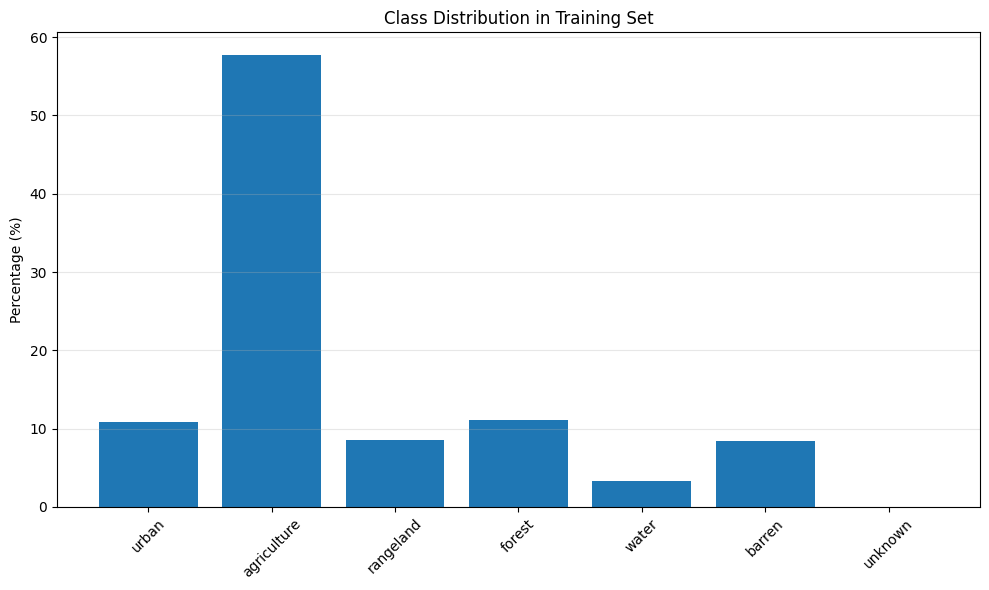

In [8]:
from tqdm import tqdm

def analyze_class_distribution(mask_dir):
    """Count pixels per class across all training masks"""
    mask_paths = sorted(glob.glob(f"{mask_dir}/*_mask.png"))

    class_counts = np.zeros(7, dtype=np.int64)

    for mask_path in tqdm(mask_paths, desc="Analyzing masks"):
        mask_rgb = np.array(Image.open(mask_path))

        for color, class_id in COLOR_MAP.items():
            match = np.all(mask_rgb == color, axis=-1)
            class_counts[class_id] += np.sum(match)

    return class_counts

# Run analysis
class_counts = analyze_class_distribution('../data/raw/train')
total_pixels = class_counts.sum()

# Calculate statistics
class_freqs = class_counts / total_pixels
class_percentages = class_freqs * 100

# Display results
print("\n=== Class Distribution ===")
for i, name in enumerate(CLASS_NAMES):
    count = class_counts[i]
    freq = class_freqs[i]
    pct = class_percentages[i]
    print(f"{name:12s}: {count:12,d} pixels ({pct:6.2f}%)")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(CLASS_NAMES, class_percentages)
ax.set_ylabel('Percentage (%)')
ax.set_title('Class Distribution in Training Set')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/figures/class_distribution.png', dpi=150)
plt.show()

## 2.4 Calculate Class Weights

**Objective:** Compute inverse frequency weights for handling class imbalance during training.

**Why this matters:**
- **Balances learning:** Rare classes get higher weights, preventing the model from ignoring minority classes
- **Improves performance:** Weighted loss functions lead to better mIoU scores on imbalanced datasets
- **Excludes unknown class:** The "unknown" class (black pixels) is ignored during training as it represents unlabeled regions
- **Smoothing prevents extremes:** A small smoothing factor prevents very rare classes from dominating the loss

The weights are normalized and will be used in the loss function (e.g., CrossEntropyLoss) to penalize misclassifications proportionally to class rarity.

In [15]:
def compute_class_weights(class_counts, ignore_index=6):
    """
    Compute inverse frequency weights for loss function

    Args:
        class_counts: Array of pixel counts per class
        ignore_index: Class to ignore (unknown)

    Returns:
        Tensor of class weights
    """
    import torch

    # Convert to float
    counts = class_counts.copy().astype(np.float64)
    
    # Calculate total pixels (excluding ignored class)
    total_pixels = counts.sum() - counts[ignore_index]
    
    # Compute inverse frequency weights for non-ignored classes
    weights = np.zeros(len(counts), dtype=np.float64)
    for i in range(len(counts)):
        if i == ignore_index:
            weights[i] = 0.0
        else:
            weights[i] = total_pixels / counts[i]
    
    # Normalize so weights sum to number of valid classes
    weight_sum = weights.sum()
    num_valid_classes = len(counts) - 1  # Exclude ignored class
    weights = weights / weight_sum * num_valid_classes

    return torch.FloatTensor(weights)

# Calculate weights
class_weights = compute_class_weights(class_counts)
print("\n=== Class Weights ===")
for i, name in enumerate(CLASS_NAMES):
    print(f"{name:12s}: {class_weights[i]:.4f}")
    
print(f"\nSum of weights (excluding ignore class): {class_weights[:6].sum():.4f}")
print("\nInterpretation:")
print("- Higher weight = rarer class (model will focus more on these)")
print("- Lower weight = common class")


=== Class Weights ===
urban       : 0.7530
agriculture : 0.1409
rangeland   : 0.9589
forest      : 0.7288
water       : 2.4558
barren      : 0.9626
unknown     : 0.0000

Sum of weights (excluding ignore class): 6.0000

Interpretation:
- Higher weight = rarer class (model will focus more on these)
- Lower weight = common class


## 2.5 Test RGB-to-ID Conversion

**Objective:** Implement and validate bidirectional conversion between RGB masks and integer class ID masks.

**Why this matters:**
- **Training requirement:** PyTorch models expect integer class labels, not RGB values
- **Memory efficiency:** Integer masks (H×W×1) use less memory than RGB masks (H×W×3)
- **Computational efficiency:** Integer indexing is faster than RGB comparisons during training
- **Reversibility:** Converting back to RGB is essential for visualizing model predictions
- **Data integrity:** Testing ensures no information is lost during conversion

This conversion will be used in the data pipeline to transform raw RGB masks into training-ready integer labels, and to visualize predictions as colored segmentation maps.

✓ RGB-to-ID conversion is correct

Original mask shape: (2448, 2448, 3) (RGB)
Converted mask shape: (2448, 2448) (Class IDs)
Reconstructed mask shape: (2448, 2448, 3) (RGB)

Memory reduction: 3.0x smaller


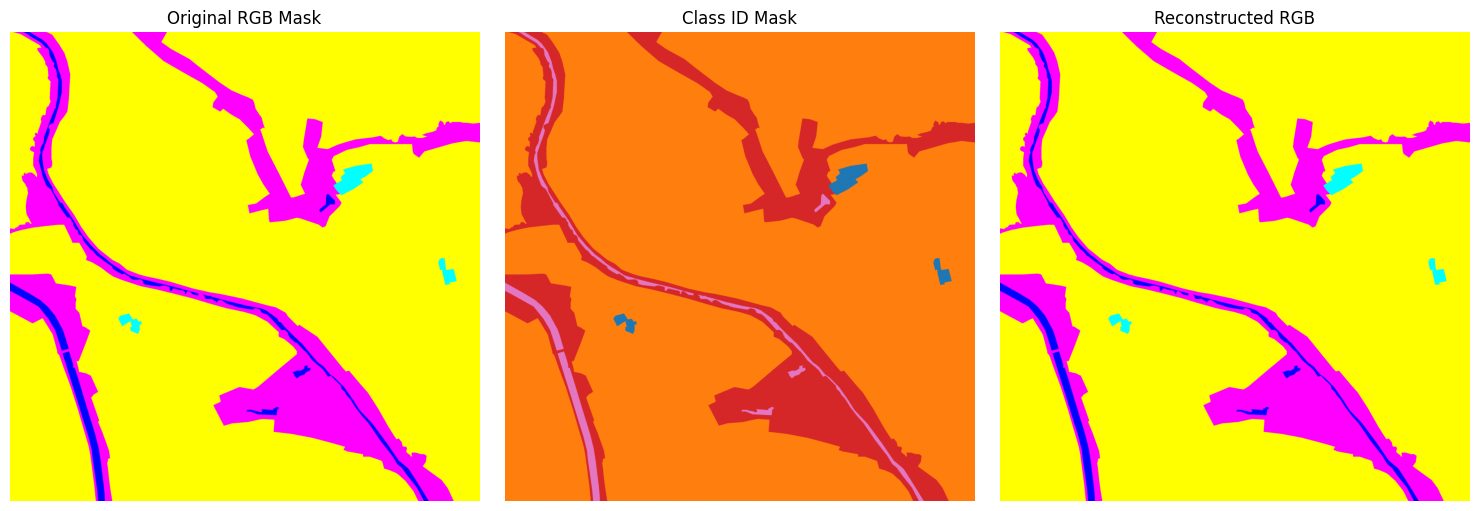

In [16]:
from typing import Dict, Tuple

def rgb_to_class_id(mask_rgb: np.ndarray,
                    color_map: Dict[Tuple[int, int, int], int]) -> np.ndarray:
    """
    Convert RGB mask to class ID mask

    Args:
        mask_rgb: RGB mask array (H, W, 3)
        color_map: Dictionary mapping RGB tuples to class IDs

    Returns:
        Class ID mask array (H, W)
    """
    h, w = mask_rgb.shape[:2]
    mask_id = np.zeros((h, w), dtype=np.uint8)

    for color, class_id in color_map.items():
        match = np.all(mask_rgb == color, axis=-1)
        mask_id[match] = class_id

    return mask_id

def class_id_to_rgb(mask_id: np.ndarray,
                    color_map: Dict[Tuple[int, int, int], int]) -> np.ndarray:
    """
    Convert class ID mask back to RGB for visualization

    Args:
        mask_id: Class ID mask (H, W)
        color_map: Dictionary mapping RGB tuples to class IDs

    Returns:
        RGB mask (H, W, 3)
    """
    h, w = mask_id.shape
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)

    # Invert color_map
    id_to_color = {v: k for k, v in color_map.items()}

    for class_id, color in id_to_color.items():
        mask_rgb[mask_id == class_id] = color

    return mask_rgb

# Test conversion with loaded mask
mask_id = rgb_to_class_id(mask, COLOR_MAP)
mask_rgb_reconstructed = class_id_to_rgb(mask_id, COLOR_MAP)

# Verify perfect reconstruction
assert np.array_equal(mask, mask_rgb_reconstructed), "Conversion failed!"
print("✓ RGB-to-ID conversion is correct")
print(f"\nOriginal mask shape: {mask.shape} (RGB)")
print(f"Converted mask shape: {mask_id.shape} (Class IDs)")
print(f"Reconstructed mask shape: {mask_rgb_reconstructed.shape} (RGB)")
print(f"\nMemory reduction: {mask.nbytes / mask_id.nbytes:.1f}x smaller")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(mask)
axes[0].set_title('Original RGB Mask')
axes[1].imshow(mask_id, cmap='tab10', vmin=0, vmax=6)
axes[1].set_title('Class ID Mask')
axes[2].imshow(mask_rgb_reconstructed)
axes[2].set_title('Reconstructed RGB')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.savefig('../outputs/figures/mask_conversion_test.png', dpi=150)
plt.show()

## 2.6 Conclusion and Key Findings

This exploratory data analysis of the DeepGlobe Land Cover dataset revealed several critical insights that will inform our model development strategy:

### Dataset Characteristics
- **Image dimensions:** 2448×2448 pixels (RGB, uint8)
- **Mask format:** RGB-encoded semantic segmentation with 7 land cover classes
- **Training set size:** 803 image-mask pairs totaling ~4.8 billion labeled pixels

### Class Imbalance Analysis
The dataset exhibits **severe class imbalance**:
- **Agriculture dominates** with 57.74% of all pixels (majority class)
- **Water is rarest** at 3.31% (17.4× less frequent than agriculture)
- **Unknown/unlabeled** regions comprise only 0.05% (can be safely ignored)

**Imbalance ratio:** 17.4:1 (most common to rarest valid class)

### Implications for Model Training

1. **Loss Function Strategy**
   - Must use weighted cross-entropy with computed class weights:
     - Water: **2.46** (highest priority)
     - Barren/Rangeland: **~0.96** (medium-high)
     - Urban/Forest: **~0.73-0.75** (medium)
     - Agriculture: **0.14** (lowest, most common)
   - Ignore class ID 6 (unknown) during training

2. **Evaluation Metrics**
   - Mean IoU (mIoU) is essential - accuracy alone will be misleading
   - Per-class IoU monitoring required to detect minority class performance
   - Expected baseline: naive model could achieve ~58% accuracy by predicting only agriculture

3. **Data Augmentation**
   - Consider oversampling tiles with rare classes (water, rangeland, barren)
   - Standard augmentations: rotation, flipping, color jittering
   - Preserve exact RGB color values in masks (no interpolation)

4. **Technical Implementation**
   - RGB→ID conversion validated with perfect reconstruction
   - 3× memory reduction using integer labels vs RGB masks
   - Pipeline ready for PyTorch DataLoader integration

### Next Steps
- Implement custom PyTorch Dataset with weighted sampling
- Create preprocessing pipeline with augmentations
- Design U-Net/DeepLabv3+ architecture with weighted loss
- Establish validation strategy with stratified splits